In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_ind_from_stats
from scipy.special import logit, expit
from sklearn.metrics import auc,roc_curve,roc_auc_score, precision_recall_curve, average_precision_score, auc, balanced_accuracy_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams['svg.fonttype'] = 'none'
rcParams['font.size']=15

Using Theano backend.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_dnst51xf.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Preallocating 10619/11178 Mb (0.950000) on cuda
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:DB:00.0)


In [2]:
classification_model_3_hg19 = load_model('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/classification_model_3.hdf5', compile=False)

In [3]:
tewhey_ref_sequences = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_one_hot_encoded_ref_sequences.npy")
tewhey_alt_sequences = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_one_hot_encoded_alt_sequences.npy")

In [4]:
ref_scores = classification_model_3_hg19.predict(tewhey_ref_sequences)
alt_scores = classification_model_3_hg19.predict(tewhey_alt_sequences)

In [2]:
ref_scores = expit(np.load("dnase_classifier_ref_scores.npy"))
alt_scores = expit(np.load("dnase_classifier_alt_scores.npy"))

In [3]:
tewhey_snp_info = pd.read_csv("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_snps_data_extended_joined_to_1kg_mappings_with_1kb_snp_centered_sequences_with_gm_overlaps.txt",
                              sep="\t")

In [4]:
tewhey_snp_info["Ref.score"] = ref_scores
tewhey_snp_info["Alt.score"] = alt_scores
tewhey_snp_info["Predicted.skew"] = logit(tewhey_snp_info["Alt.score"]) - logit(tewhey_snp_info["Ref.score"])

                 MPRA_log2FC  log2ModelScores
MPRA_log2FC         1.000000         0.215671
log2ModelScores     0.215671         1.000000
                 MPRA_log2FC  log2ModelScores
MPRA_log2FC         1.000000         0.256824
log2ModelScores     0.256824         1.000000


/home/eramamur/bin/miniconda3/envs/gpu_keras_theano/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


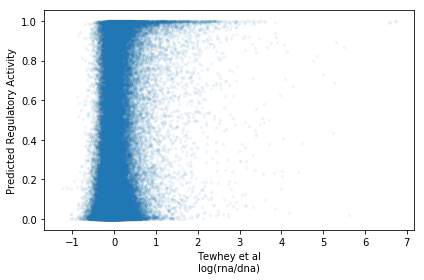

In [5]:
plt.scatter(tewhey_snp_info["C.B.log2FC"], tewhey_snp_info["Alt.score"], c='C0', s=5, alpha=0.05)
plt.scatter(tewhey_snp_info["C.A.log2FC"], tewhey_snp_info["Ref.score"], c='C0', s=5, alpha=0.05)
plt.xlabel("Tewhey et al\nlog(rna/dna)")
plt.ylabel("Predicted Regulatory Activity")
plt.savefig("dnase_classifier_predicted_activity_vs_mpra_activity_scatter.svg")

corr_frame = pd.DataFrame({
                           "MPRA_log2FC":np.concatenate((np.array(tewhey_snp_info["C.A.log2FC"]),
                                                          np.array(tewhey_snp_info["C.B.log2FC"]))),
                           "log2ModelScores":np.concatenate((np.array(tewhey_snp_info["Ref.score"]),
                                                           np.array(tewhey_snp_info["Alt.score"])))
                           })

print(corr_frame.corr(method="spearman"))
print(corr_frame.corr(method="pearson"))

In [6]:
tewhey_snp_info["Alt.score"].isna().sum()

0

(nan, 1.0)
SpearmanrResult(correlation=nan, pvalue=nan)


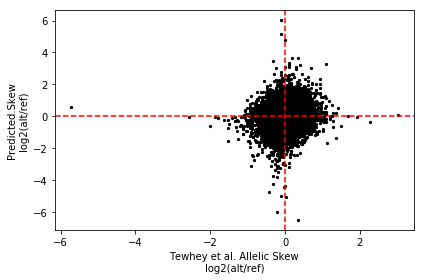

In [13]:
plt.scatter(tewhey_snp_info["LogSkew.Comb"],tewhey_snp_info["Predicted.skew"] , c = 'k', s=5)
plt.axhline(y=0, c='r', linestyle='--')
plt.axvline(x=0, c='r', linestyle='--')
plt.xlabel("Tewhey et al. Allelic Skew\nlog2(alt/ref)")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
print(pearsonr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))

(nan, 1.0)
SpearmanrResult(correlation=nan, pvalue=nan)


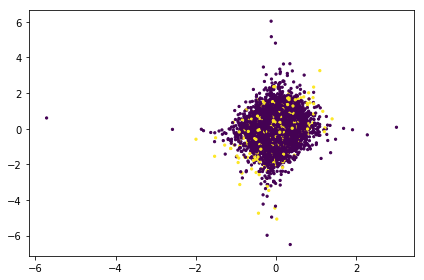

In [14]:
plt.scatter(tewhey_snp_info["LogSkew.Comb"], tewhey_snp_info["Predicted.skew"], c = tewhey_snp_info["Num.Overlaps.GM.peaks"]>0, s=5)
print(pearsonr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info["LogSkew.Comb"]), tewhey_snp_info["Predicted.skew"]))

In [11]:
tewhey_snp_info_sig = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]

x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
y = []
for cutoff in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    tewhey_snp_info_sig_cutoff = tewhey_snp_info_sig[np.absolute(tewhey_snp_info_sig["LogSkew.Comb"])>cutoff]
    num_correct = ((tewhey_snp_info_sig_cutoff["LogSkew.Comb"] * tewhey_snp_info_sig_cutoff["Predicted.skew"]) > 0).sum()
    num_wrong = ((tewhey_snp_info_sig_cutoff["LogSkew.Comb"] * tewhey_snp_info_sig_cutoff["Predicted.skew"]) < 0).sum()
    y.append(1*num_correct/(num_correct+num_wrong))

In [12]:
print(y)

[0.6385302879841113, 0.6526429341963322, 0.6671105193075899, 0.6788321167883211, 0.6726342710997443, 0.6977611940298507, 0.7216494845360825, 0.765625, 0.776595744680851, 0.7592592592592593]


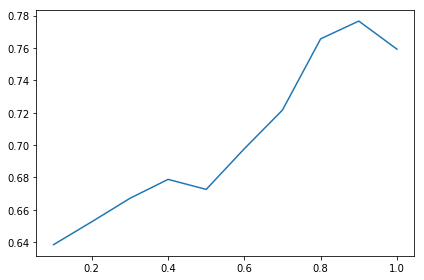

In [15]:
plt.plot(x,y)
plt.ylim([0])

(0.4243977509774407, 1.5816200280686107e-18)
SpearmanrResult(correlation=0.4241220233912964, pvalue=1.6729291673659525e-18)


/home/eramamur/bin/miniconda3/envs/gpu_keras_theano/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


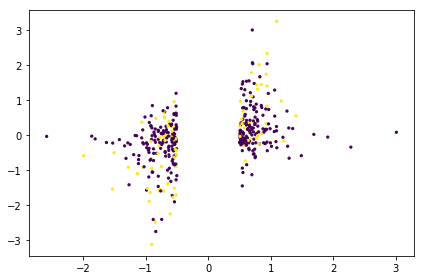

In [22]:
plt.scatter(tewhey_snp_info_sig["LogSkew.Comb"], tewhey_snp_info_sig["Predicted.skew"], c= tewhey_snp_info_sig["Num.Overlaps.GM.peaks"]>0, s=5)
print(pearsonr(np.nan_to_num(tewhey_snp_info_sig["LogSkew.Comb"]), tewhey_snp_info_sig["Predicted.skew"]))
print(spearmanr(np.nan_to_num(tewhey_snp_info_sig["LogSkew.Comb"]), tewhey_snp_info_sig["Predicted.skew"]))

In [6]:
tewhey_snp_info_pos = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_pos = tewhey_snp_info_pos[tewhey_snp_info_pos["LogSkew.Comb"]>0.5]

tewhey_snp_info_neg = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_neg = tewhey_snp_info_neg[tewhey_snp_info_neg["LogSkew.Comb"]< -0.5]


tewhey_snp_info_neutral = tewhey_snp_info[tewhey_snp_info["C.Skew.fdr"] < -np.log10(0.05)]
tewhey_snp_info_neutral = tewhey_snp_info_neutral[np.absolute(tewhey_snp_info_neutral["LogSkew.Comb"]) < 0.2]

In [7]:
tewhey_snp_info_neutral["Predicted.skew"].isna().sum()

4

Ttest_1sampResult(statistic=-7.74391000506734, pvalue=4.4918783827958854e-13)
Ttest_1sampResult(statistic=nan, pvalue=nan)
Ttest_1sampResult(statistic=5.848296940429996, pvalue=2.1949868034644394e-08)
Ttest_indResult(statistic=-7.765732194610594, pvalue=3.21475117990093e-13)
Ttest_indResult(statistic=5.663415322038114, pvalue=5.202491428564179e-08)


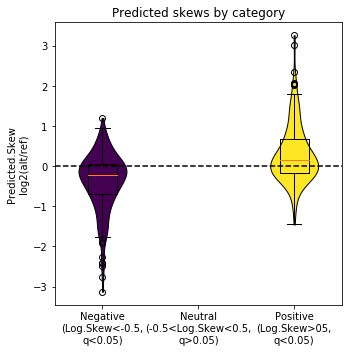

In [10]:
fig, ax = plt.subplots(figsize=(5,5))

parts = ax.violinplot(dataset=[tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()],showmedians=False,showextrema=False)

parts['bodies'][0].set_facecolor('#440154FF')
parts['bodies'][0].set_edgecolor('black')
parts['bodies'][0].set_alpha(1)

parts['bodies'][1].set_facecolor('#238A8DFF')
parts['bodies'][1].set_edgecolor('black')
parts['bodies'][1].set_alpha(1)    


parts['bodies'][2].set_facecolor('#FDE725FF')
parts['bodies'][2].set_edgecolor('black')
parts['bodies'][2].set_alpha(1)   

plt.boxplot([tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()])
plt.axhline(y=0, c='k', linestyle='--')
plt.xticks(ticks = range(1,4), labels = ["Negative\n(Log.Skew<-0.5,\nq<0.05)", "Neutral\n(-0.5<Log.Skew<0.5,\nq>0.05)", "Positive\n(Log.Skew>05,\nq<0.05)"], horizontalalignment="center")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
plt.title("Predicted skews by category")
plt.savefig("classifier_predicted_skew_binned_peaks_only.svg")
print(ttest_1samp(tewhey_snp_info_neg["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_neutral["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_pos["Predicted.skew"].tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_neg["Predicted.skew"]),
                     np.std(tewhey_snp_info_neg["Predicted.skew"]),
                     len(tewhey_snp_info_neg["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_pos["Predicted.skew"]),
                     np.std(tewhey_snp_info_pos["Predicted.skew"]),
                     len(tewhey_snp_info_pos["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))

In [29]:
tewhey_snp_info_overlapping_peaks = tewhey_snp_info[tewhey_snp_info["Num.Overlaps.GM.peaks"]>0]
tewhey_snp_info_pos = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_pos = tewhey_snp_info_pos[tewhey_snp_info_pos["LogSkew.Comb"]>0.5]

tewhey_snp_info_neg = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] > -np.log10(0.05)]
tewhey_snp_info_neg = tewhey_snp_info_neg[tewhey_snp_info_neg["LogSkew.Comb"]< -0.5]


tewhey_snp_info_neutral = tewhey_snp_info_overlapping_peaks[tewhey_snp_info_overlapping_peaks["C.Skew.fdr"] < -np.log10(0.05)]
tewhey_snp_info_neutral = tewhey_snp_info_neutral[np.absolute(tewhey_snp_info_neutral["LogSkew.Comb"]) < 0.2]

Ttest_1sampResult(statistic=-5.562435412045482, pvalue=9.364145304830393e-07)
Ttest_1sampResult(statistic=nan, pvalue=nan)
Ttest_1sampResult(statistic=4.641975937115228, pvalue=4.2391428239287924e-05)
Ttest_indResult(statistic=-5.765343601119385, pvalue=3.9222156240165244e-07)
Ttest_indResult(statistic=4.475577345972908, pvalue=6.62798369625963e-05)


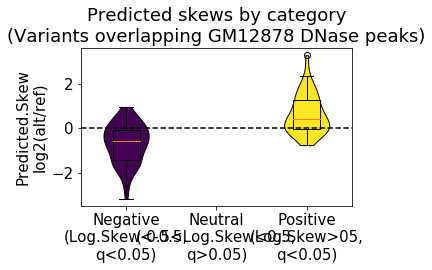

In [31]:
fig, ax = plt.subplots()

parts = ax.violinplot(dataset=[tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()],showmedians=False,showextrema=False)

parts['bodies'][0].set_facecolor('#440154FF')
parts['bodies'][0].set_edgecolor('black')
parts['bodies'][0].set_alpha(1)

parts['bodies'][1].set_facecolor('#238A8DFF')
parts['bodies'][1].set_edgecolor('black')
parts['bodies'][1].set_alpha(1)    


parts['bodies'][2].set_facecolor('#FDE725FF')
parts['bodies'][2].set_edgecolor('black')
parts['bodies'][2].set_alpha(1)   

plt.boxplot([tewhey_snp_info_neg["Predicted.skew"].tolist(), tewhey_snp_info_neutral["Predicted.skew"].tolist(), tewhey_snp_info_pos["Predicted.skew"].tolist()])
plt.axhline(y=0, c='k', linestyle='--')
plt.xticks(ticks = range(1,4), labels = ["Negative\n(Log.Skew<-0.5,\nq<0.05)", "Neutral\n(-0.5<Log.Skew<0.5,\nq>0.05)", "Positive\n(Log.Skew>05,\nq<0.05)"], horizontalalignment="center")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
plt.title("Predicted skews by category\n(Variants overlapping GM12878 DNase peaks)")
print(ttest_1samp(tewhey_snp_info_neg["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_neutral["Predicted.skew"].tolist(),0))
print(ttest_1samp(tewhey_snp_info_pos["Predicted.skew"].tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_neg["Predicted.skew"]),
                     np.std(tewhey_snp_info_neg["Predicted.skew"]),
                     len(tewhey_snp_info_neg["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_pos["Predicted.skew"]),
                     np.std(tewhey_snp_info_pos["Predicted.skew"]),
                     len(tewhey_snp_info_pos["Predicted.skew"].tolist()),
                     np.mean(tewhey_snp_info_neutral["Predicted.skew"]),
                     np.std(tewhey_snp_info_neutral["Predicted.skew"]),
                     len(tewhey_snp_info_neutral["Predicted.skew"].tolist()),
                     equal_var=False))

In [8]:
def evaluate_model(X,Y,model):
    pred = model.predict_proba(X)
    
    fpr, tpr, thresholds = roc_curve(Y, pred, pos_label=1)
    auRoc = auc(fpr, tpr)

    precision, recall, thresholds = precision_recall_curve(Y,pred)
    auPrc = auc(recall, precision)
    averagePrecision = average_precision_score(Y, pred)
    pred_binary = pred>0.5
    balancedAccuracy = balanced_accuracy_score(Y, pred_binary)
    
    negativeClassTrue = []
    negativeClassPred = []
    positiveClassTrue = []
    positiveClassPred = []
    
    for i, val in enumerate(Y):
        currTrueLabel = Y[i]
        currPred = pred_binary[i]
        if currTrueLabel == 0:
            negativeClassTrue.append(currTrueLabel)
            negativeClassPred.append(currPred)
        else:
            positiveClassTrue.append(currTrueLabel)
            positiveClassPred.append(currPred)            

            
    negativeClassTrue = np.array(negativeClassTrue)
    negativeClassPred = np.array(negativeClassPred)
    positiveClassTrue = np.array(positiveClassTrue)
    positiveClassPred = np.array(positiveClassPred)
    
    negativeAccuracy = accuracy_score(negativeClassTrue, negativeClassPred)
    positiveAccuracy = accuracy_score(positiveClassTrue, positiveClassPred)
    
    print("auROC:",auRoc)
    print("Average precision:",averagePrecision)
    print("auPRC:",auPrc)
    print("Balanced Accuracy:",balancedAccuracy)
    print("Positive Accuracy:",positiveAccuracy)
    print("Negative Accuracy:",negativeAccuracy)
    print("Classification Report:")
    print(classification_report(Y, pred_binary))
    
    plt.figure()

    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title("ROC (AUC: " +str(round(auRoc,2))+")")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.saveif()
    
    plt.figure()    
    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.title("Precision-Recall (AUC: " +str(round(auPrc,2))+")")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()


In [9]:
#X_train = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chrs_training_summit_centered_training_set_hg19_classification_X.npy')
#Y_train = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chrs_training_summit_centered_training_set_hg19_classification_Y.npy')
X_valid = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chr4_summit_centered_validation_set_hg19_classification_X.npy')
Y_valid = np.load('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/chr4_summit_centered_validation_set_hg19_classification_Y.npy')

auROC: 0.9638296439303305
Average precision: 0.9732517283186506
auPRC: 0.9732476995722017
Balanced Accuracy: 0.9011065724685168
Positive Accuracy: 0.9229583975346687
Negative Accuracy: 0.8792547474023648
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.89      2791
         1.0       0.91      0.92      0.92      3894

   micro avg       0.90      0.90      0.90      6685
   macro avg       0.90      0.90      0.90      6685
weighted avg       0.90      0.90      0.90      6685



/home/eramamur/bin/miniconda3/envs/gpu_keras_theano/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


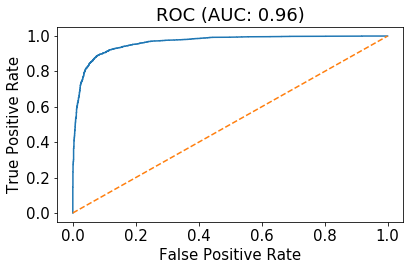

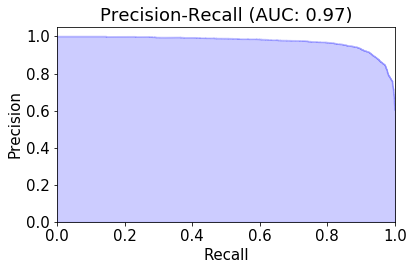

In [10]:
evaluate_model(X_valid,Y_valid,classification_model_3_hg19)

In [ ]:
evaluate_model(X_train,Y_train,classification_model_3_hg19)

In [5]:
tewhey_snp_info_pos.shape

NameError: name 'tewhey_snp_info_pos' is not defined